# 1. Import Library

In [1]:
import os
import sys
import time
import datetime
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import save_image
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import torch.nn.functional as F
import urllib
import glob
import skimage.io as skio
from torch.utils.data import Dataset
import random
import pandas as pd

# 2. Preprocess data

In [2]:
# Set several hyperparameters and settings

batch_size = 128 # size of dataset

n_epoch = 12 # times of training

learning_rate = 0.001 # learning_rate >> -> learn faster -> accuracy <<

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # to tensor before normalize
])
validation_transform = transforms.Compose([
#     transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # to tensor @ Normalize must be at the end
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # to tensor before normalize
])

shuffle = False
target_transform = None

In [3]:
seed = 123
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
def load_image(file):
    return Image.open(file)
def image_path(root, basename, extension):
    return os.path.join(root, f'{basename}{extension}')

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        video_files = os.listdir(img_dir)
        self.labels = list()
        self.imgs = list()
        for file_name in video_files:
            cur_csv = pd.read_csv(os.path.join(label_dir, file_name+'.csv'))
            cur_len = len(cur_csv.index)
            for itr in range(cur_len):
                img_file_dir = os.path.join(os.path.join(img_dir, file_name), cur_csv.iloc[itr, 0] + '.PNG')
                self.imgs.append(img_file_dir) # image directory
                self.labels.append([cur_csv.iloc[itr, 0], cur_csv.iloc[itr, 1]]) # label
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform

    def __getitem__(self, index):
        with open(self.imgs[index], 'rb') as f:
            image = load_image(f).convert('RGB')
        label = self.labels[index][1]
        filename = self.labels[index][0]

#         image, label = self.spm_transform(image, label)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.labels)

img_dir = r'../input/hsgs-hackathon2022/train_data/Train'
label_dir = r'../input/hsgs-hackathon2022/train_data/Train_labels'
dataset = CustomImageDataset(img_dir=img_dir, label_dir=label_dir, transform=transform)
n_train = math.floor(0.9*len(dataset)) # (default) 90% of the data for training
n_val = len(dataset) - math.floor(0.9*len(dataset)) # (default) 10% of the data for validation

train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=False, drop_last = True)

classes = ('Hit', 'no_label')

In [ ]:
[one_batch_data, one_batch_label] = next(iter(train_loader))
print(one_batch_data.size(), one_batch_label.size())   #check the size of the batches and labels

torch.Size([128, 3, 224, 224]) torch.Size([128])


# 3. Build model

In [ ]:
class cLinear(nn.Module):
    # in_channels = 512
    def __init__(self, in_channels, out_channels, dropout=0):
        super().__init__()
        layers = [
            nn.Linear(in_channels, 64),
            nn.Dropout(p=0.3),
            nn.Linear(64, out_channels),
        ]
        self.fward = nn.Sequential(*layers)

    def forward(self, x):
        return self.fward(x)

model = torchvision.models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
fc_in_ftrs = model.fc.in_features
print(fc_in_ftrs)
model.fc = cLinear(fc_in_ftrs, 2)
print(model)

In [ ]:
# convert img tensor to a NumPy array
def vismod_img(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

# display the first 8 image in the input data along with their labels
def show_data(data, label, classes):
    num_row = 2
    num_col = 4
    fig, axes = plt.subplots(num_row, num_col)
    for i in range(8):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(vismod_img(data[i].cpu()))
        ax.set_title(f'label : {classes[label[i].cpu().item()]}')
    plt.tight_layout()
    plt.show()

# show the output predictions along with labels
def show_inference_result(data, label, output, classes):
    num_row = 2
    num_col = 4
    fig, axes = plt.subplots(num_row, num_col)
    for i in range(8):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(vismod_img(data[i].cpu()))
#         print('checkclass', label[i].cpu().item())
        ax.set_title(f'GT : {classes[label[i].cpu().item()]} \n output : {classes[output[i].cpu().item()]}')
    plt.tight_layout()
    plt.show()

(Training Data) ground truth example


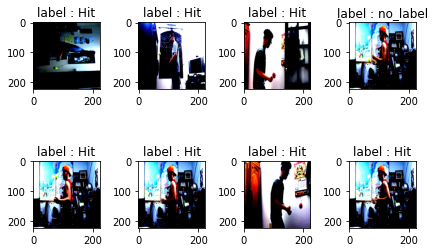

In [ ]:
# show ground truth classification (one batch)
print('(Training Data) ground truth example')
show_data(one_batch_data, one_batch_label, classes) # 10

current classification


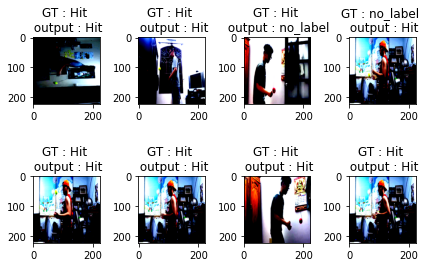

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        bound = 1 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, bound)
        nn.init.uniform_(m.bias, -bound, bound)

def thresholding(prediction):
    _, pred_label = torch.max(prediction, 1)
    return pred_label

my_classifier = model  # assign classifier
my_classifier = my_classifier.to(device)
# my_classifier.apply(weights_init)  # applying weights_init function to linear layers

# show the performance of untrained classifier
print('current classification')
prediction = my_classifier(one_batch_data.to(device))  # passing forward function of classifier, return prediction
show_inference_result(one_batch_data, one_batch_label, thresholding(prediction), classes)

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
print(get_n_params(my_classifier))

58275074


In [ ]:
optimizer = torch.optim.Adam(my_classifier.parameters(), lr=learning_rate, weight_decay=0.001)

# 4. Train


In [ ]:
my_classifier.load_state_dict(torch.load("./checkpoint.pth", map_location=torch.device('cpu')))

In [ ]:
# train cnn classifier
train_loss_iter = np.zeros(n_epoch, dtype=float)  # Temporary numpy array to save loss for each epoch
validation_loss_iter = np.zeros(n_epoch, dtype=float)
train_accuracy_iter = np.zeros(n_epoch, dtype=float)  # Temporary numpy array to save accuracy for each epoch
validation_accuracy_iter = np.zeros(n_epoch, dtype=float)

loss_function = torch.nn.CrossEntropyLoss()
# Assign cross-entropy loss
best_model_state = None
best_acc = 0.0

for epoch in range(n_epoch):  # We will iteratively find optimum
    # Training
    my_classifier.train()
    total_loss, total_cnt, correct_cnt = 0.0, 0.0, 0.0

    for batch_idx, (image, label) in enumerate(train_loader): # current len(train_loader) = 390
        image, label = image.to(device), label.to(device)
        pred = my_classifier(image)  # Find output of classifier

        optimizer.zero_grad()  # Pytorch does not overwrite gradients, it 'accumulates' them so that we need to set gradient as 0 to update parameter correctly
        loss = loss_function(pred, label)  # Calculate cross-entropy loss between prediction and label
        loss.backward()  # Pytorch automatically back-propagate and calculate gradients
        optimizer.step()  # From calculated gradients, change parameters of classifier with SGD algorithm

        total_loss += loss.item()
        total_cnt += len(label)
        correct_cnt += (pred.argmax(1) == label).type(torch.float).sum().item()


    accuracy = correct_cnt * 1.0 / total_cnt
    train_loss_iter[epoch] = total_loss / total_cnt
    train_accuracy_iter[epoch] = accuracy


    print(f"[{str(epoch).zfill(len(str(n_epoch)))}/{n_epoch}] Train Loss  : {train_loss_iter[epoch]:.6f}, Acc = {100*train_accuracy_iter[epoch]:.2f}%")

    # validation
    my_classifier.eval()
    total_loss, total_cnt, correct_cnt = 0.0, 0.0, 0.0
    for batch_idx, (image, label) in enumerate(validation_loader):
        with torch.no_grad():
            image, label = image.to(device), label.to(device)

            pred = my_classifier(image)
            loss = loss_function(pred, label)

            total_loss += loss.item()
            total_cnt += len(label)
            correct_cnt += (pred.argmax(1) == label).type(torch.float).sum().item()

    accuracy = correct_cnt * 1.0 / total_cnt
    validation_loss_iter[epoch]  = total_loss / total_cnt
    validation_accuracy_iter[epoch] = accuracy

    if best_acc < accuracy:
        best_acc = accuracy
        best_model_state = my_classifier.state_dict()

    print(f"[{str(epoch).zfill(len(str(n_epoch)))}/{n_epoch}] Validation Loss : {validation_loss_iter[epoch]:.6f}, Acc = {100*validation_accuracy_iter[epoch]:.2f}%")

In [ ]:
# show loss during training
l1, = plt.plot(range(1,n_epoch+1), train_loss_iter)
l2, = plt.plot(range(1,n_epoch+1), validation_loss_iter)
plt.legend(handles=(l1, l2), labels=('Train loss', 'Valid loss'))

In [ ]:
# show accuracy during training
l1, = plt.plot(range(1,n_epoch+1), 100*train_accuracy_iter)
l2, = plt.plot(range(1,n_epoch+1), 100*validation_accuracy_iter)
plt.legend(handles=(l1, l2), labels=('Train Acc', 'Valid Acc'))

In [ ]:
# For validation data
print('After training')
[one_batch_data, one_batch_label] = next(iter(validation_loader))
prediction = my_classifier(one_batch_data.to(device))
show_inference_result(one_batch_data, one_batch_label, thresholding(prediction), classes)

In [ ]:
model_save_name = 'checkpoint2.pth'
path = F"{model_save_name}"

#torch.save(checkpoint, path)
torch.save(best_model_state, path)

# 5. Test

In [ ]:
class GetData(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        video_files = os.listdir(img_dir)
        self.labels = list()
        self.imgs = list()
        for folder_name in video_files:
            file_name = os.listdir(img_dir + '/' + folder_name)
            for img_name in file_name:
                img_file_dir = img_dir + '/' + folder_name +'/' + img_name
                self.imgs.append(img_file_dir) # image directory
                self.labels.append([folder_name+'_'+img_name[:12], 1]) # label

        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform

    def __getitem__(self, index):
        with open(self.imgs[index], 'rb') as f:
            image = load_image(f).convert('RGB')
        label = self.labels[index][1]
        filename = self.labels[index][0]

#         image, label = self.spm_transform(image, label)

        if self.transform is not None:
            image = self.transform(image)

        return image, filename

    def __len__(self):
        return len(self.labels)

In [ ]:
test_dir = r'../input/hsgs-hackathon2022/Test_data/Test'
testset = GetData(test_dir, None, transform)
#test_dataset = torch.utils.data.random_split(testset, len(testset))
test_loader = torch.utils.data.DataLoader(testset, batch_size = 8, shuffle=False)

In [ ]:
s_ls = []

with torch.no_grad():
    my_classifier.eval()
    for image, fname in test_loader:
        image = image.to(device)

        logits = my_classifier(image)
        ps = torch.exp(logits)
        _, top_class = ps.topk(1, dim=1)
        i=0
        for pred in top_class:
            s_ls.append([fname[i], pred.item()])
            print(fname[i], pred.item())
            i+=1

In [ ]:
# Detect
s_ls.sort(reverse=False)
i=0
while i<len(s_ls):
  if s_ls[i][1]==1:
    if(i+1<len(s_ls) and s_ls[i][0][:12]==s_ls[i+1][0][:12]):
      s_ls[i+1][1]=1
    if(i>0 and s_ls[i][0][:12]==s_ls[i-1][0][:12]):
      s_ls[i-1][1]=1
    i+=1
  i+=1

# #  Counter
# i = 1
# cnt = 0
# if s_ls[0][1] == 1:
#   cnt += 1
# while i < len(s_ls):
#   if s_ls[i][1] == 1 and s_ls[i-1][1] == 0:
#     cnt += 1

# cnt.to_csv("submission.csv", index=False)

In [ ]:
sub = pd.DataFrame.from_records(s_ls, columns=['Frame', 'Label'])
sub.head()

In [ ]:
sub.to_csv("submission.csv", index=False)